In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Libraries
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import plot_model, model_to_dot
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization

In [ ]:
keras.backend.set_image_data_format('channels_last')

In [ ]:
def evaluate(predicted_outcome, expected_outcome):
    from sklearn import metrics
    f1_score = metrics.f1_score(expected_outcome, predicted_outcome, average='weighted')
    balanced_accuracy_score = metrics.balanced_accuracy_score(expected_outcome, predicted_outcome)
    return f1_score, balanced_accuracy_score

In [ ]:
# Data Preprocessing
def load_dataset_with_processing(input_train_test_fn, num_classes=10):
    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

    # split validation set
    from sklearn.model_selection import train_test_split
    X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

    X_train = np.array(X_train, dtype="float") / 255.0
    X_train = X_train.reshape(X_train.shape[0], 28, 28,1 )
    print(X_train.shape)

    X_vali = np.array(X_vali, dtype="float") / 255.0
    X_vali = X_vali.reshape(X_vali.shape[0], 28, 28,1 )
    print(X_vali.shape)

    X_test = np.array(X_test, dtype="float") / 255.0
    X_test = X_test.reshape(X_test.shape[0], 28, 28,1 )
    print(X_test.shape)

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_vali = keras.utils.to_categorical(y_vali, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return X_train, y_train, X_vali, y_vali, X_test, y_test

In [ ]:
# Creating a data generator for real-time data augmentation
def myGenerator(X_train, y_train, batch_size):
    total_size = X_train.shape[0]

    while True:
        permutation = list(np.random.permutation(total_size))
        for i in range(total_size//batch_size):
            index = permutation[i * batch_size : (i + 1) * batch_size]
            X_batch = X_train[index]
            y_batch = y_train[index]

            yield X_batch, y_batch

In [ ]:
# Define RESNET50 Model
def build_model(input_shape, num_classes):
    model = Sequential([
        # Layer 1
        Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

        # Layer 2
        Conv2D(64, (1, 1), activation='relu'),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (1, 1), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

        # Layer 3
        Conv2D(128, (1, 1), activation='relu'),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        Conv2D(512, (1, 1), activation='relu'),
        BatchNormalization(),

        # Layer 4
        Conv2D(256, (1, 1), activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        Conv2D(1024, (1, 1), activation='relu'),
        BatchNormalization(),

        # Layer 5
        Conv2D(512, (1, 1), activation='relu'),
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        Conv2D(2048, (1, 1), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

        # Flatten
        Flatten(),

        # Layer 6
        Dense(2048, activation='relu'),
        Dropout(0.5),

        # Layer 7
        Dense(2048, activation='relu'),
        Dropout(0.5)
    ])

    for layer in model.layers:
        layer.trainable = False  # freeze the previous layers

    X = model.output
    # softmax classifier
    predictions = Dense(10, activation='softmax')(X)
    old_model = Model(inputs=model.input, outputs=predictions)

    # load weights
    old_model.load_weights('/content/drive/MyDrive/pretrained_mnist/resnet50.h5')

    X = model.output
    # softmax classifier
    predictions = Dense(num_classes, activation='softmax')(X)
    new_model = Model(inputs=model.input, outputs=predictions)
    new_model.summary()

    return new_model

input_shape = (28, 28, 1)
num_classes = 100
model = build_model(input_shape, num_classes)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_5 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 64)          4160      
                                                           

In [ ]:
def train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs):
    import os
    if os.path.exists(checkpoint_dir) is False:
        os.makedirs(checkpoint_dir)

    model = build_model(input_shape, num_classes)

    checkpoint = ModelCheckpoint(checkpoint_dir + 'best_resnet.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    datagen = myGenerator(X_train, y_train, batch_size)

    history = model.fit(datagen,
                        steps_per_epoch = len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[es, checkpoint],
                        verbose=2,
                        validation_data=(X_vali, y_vali))

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

    return model

In [ ]:
def test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights):
    model = build_model(input_shape, num_classes)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    # load weights
    model.load_weights(pretrained_weights)

    score = model.evaluate(X_test, y_test, verbose=0)

    testPredict = model.predict(X_test)
    y_test_tmp = np.argmax(y_test, axis=1)
    y_pred_tmp = np.argmax(testPredict, axis=1)
    f1_score, balanced_accuracy_score = evaluate(y_pred_tmp, y_test_tmp)

    return score[1], f1_score, balanced_accuracy_score  # return accuracies

Training RESNET50 on individual datasets



(5280, 28, 28, 1)
(1320, 28, 28, 1)
(1000, 28, 28, 1)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_10 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 64)          4160      
     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 - 10s - loss: 0.8292 - accuracy: 0.7954 - val_loss: 0.4387 - val_accuracy: 0.8720 - 10s/epoch - 255ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.87197
41/41 - 1s - loss: 0.5558 - accuracy: 0.8409 - val_loss: 0.4897 - val_accuracy: 0.8386 - 1s/epoch - 27ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.87197 to 0.88561, saving model to ./ADRIS_RESNET_MNIST_MIX/best_lenet.hdf5
41/41 - 1s - loss: 0.5484 - accuracy: 0.8436 - val_loss: 0.3626 - val_accuracy: 0.8856 - 1s/epoch - 33ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.88561
41/41 - 1s - loss: 0.5742 - accuracy: 0.8367 - val_loss: 0.3818 - val_accuracy: 0.8742 - 810ms/epoch - 20ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.88561
41/41 - 1s - loss: 0.5860 - accuracy: 0.8413 - val_loss: 0.3852 - val_accuracy: 0.8705 - 737ms/epoch - 18ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.88561 to 0.88712, saving model to ./ADRIS_RESNET_MNIST_MIX/best_lenet.hdf5
41

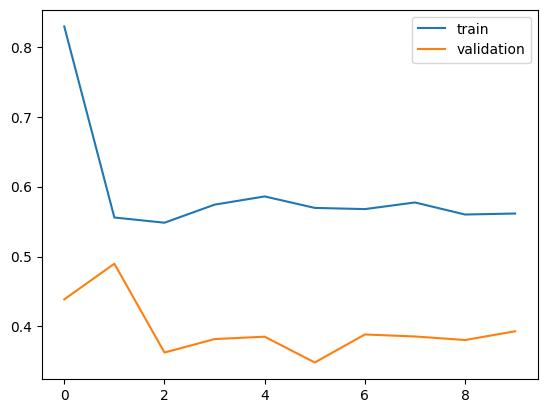

In [ ]:
# Training on ARDIS Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ADRIS_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/ARDIS_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on ADRIS test data
pretrained_weights = '/content/ADRIS_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_39 (Conv2D)          (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_15 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 7, 7, 64)          4160      
                                                           

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_52 (Conv2D)          (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_20 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 7, 7, 64)          4160      
       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 3s - loss: 2.1700 - accuracy: 0.3911 - val_loss: 1.5209 - val_accuracy: 0.5479 - 3s/epoch - 174ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.54792 to 0.56875, saving model to ./ARABIC_RESNET_MNIST_MIX/best_lenet.hdf5
15/15 - 1s - loss: 1.5346 - accuracy: 0.5312 - val_loss: 1.2909 - val_accuracy: 0.5688 - 1s/epoch - 73ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.56875 to 0.59375, saving model to ./ARABIC_RESNET_MNIST_MIX/best_lenet.hdf5
15/15 - 1s - loss: 1.5232 - accuracy: 0.5354 - val_loss: 1.1627 - val_accuracy: 0.5938 - 591ms/epoch - 39ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.59375 to 0.60833, saving model to ./ARABIC_RESNET_MNIST_MIX/best_lenet.hdf5
15/15 - 1s - loss: 1.4334 - accuracy: 0.5370 - val_loss: 1.0801 - val_accuracy: 0.6083 - 663ms/epoch - 44ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.60833
15/15 - 0s - loss: 1.4375 - accuracy: 0.5521 - val_loss: 1.1179 - val_accuracy: 0.6000 - 266ms/epoch - 18ms/step

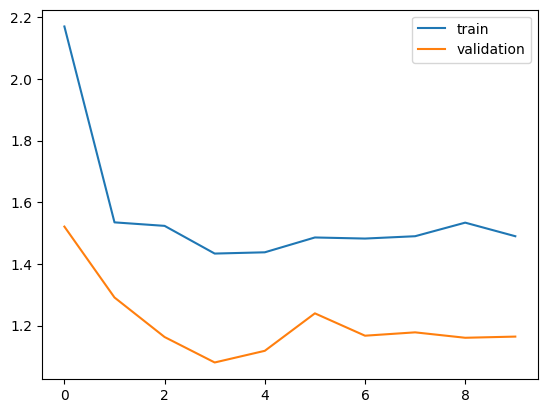

In [ ]:
# Training on CMATTERDB 3.3.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ARABIC_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Arabic_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTER 3.3.1 test data
pretrained_weights = '/content/ARABIC_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_65 (Conv2D)          (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_25 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_66 (Conv2D)          (None, 7, 7, 64)          4160      
                                                          

(12638, 28, 28, 1)
(3160, 28, 28, 1)
(3950, 28, 28, 1)
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_78 (Conv2D)          (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_30 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_79 (Conv2D)          (None, 7, 7, 64)          4160      
   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 3s - loss: 1.4354 - accuracy: 0.5911 - val_loss: 0.9901 - val_accuracy: 0.6785 - 3s/epoch - 34ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.67848
98/98 - 1s - loss: 1.3232 - accuracy: 0.6258 - val_loss: 1.0424 - val_accuracy: 0.6649 - 1s/epoch - 15ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.67848 to 0.71361, saving model to ./BANGLALEKHA_RESNET_MNIST_MIX/best_lenet.hdf5
98/98 - 2s - loss: 1.2998 - accuracy: 0.6315 - val_loss: 0.8818 - val_accuracy: 0.7136 - 2s/epoch - 19ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.71361
98/98 - 2s - loss: 1.3315 - accuracy: 0.6299 - val_loss: 0.9759 - val_accuracy: 0.6687 - 2s/epoch - 17ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.71361
98/98 - 2s - loss: 1.3647 - accuracy: 0.6287 - val_loss: 0.9245 - val_accuracy: 0.6946 - 2s/epoch - 17ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.71361
98/98 - 2s - loss: 1.3451 - accuracy: 0.6316 - val_loss: 0.9477 - v

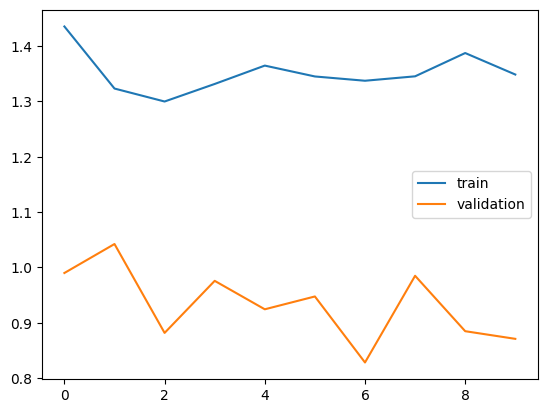

In [ ]:
# Training on BanglaLekha Isolated Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './BANGLALEKHA_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/BanglaLekha_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on BanglaLekha Isolated test data
pretrained_weights = '/content/BANGLALEKHA_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_91 (Conv2D)          (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_35 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_92 (Conv2D)          (None, 7, 7, 64)          4160      
                                                          

(3840, 28, 28, 1)
(960, 28, 28, 1)
(1200, 28, 28, 1)
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_104 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_40 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         (None, 7, 7, 64)          4160      
     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 - 2s - loss: 1.7757 - accuracy: 0.5138 - val_loss: 1.0514 - val_accuracy: 0.6771 - 2s/epoch - 80ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.67708 to 0.69687, saving model to ./BANGLA_RESNET_MNIST_MIX/best_lenet.hdf5
30/30 - 1s - loss: 1.3681 - accuracy: 0.5841 - val_loss: 0.9633 - val_accuracy: 0.6969 - 831ms/epoch - 28ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.69687
30/30 - 0s - loss: 1.3266 - accuracy: 0.6036 - val_loss: 1.0716 - val_accuracy: 0.6833 - 461ms/epoch - 15ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.69687
30/30 - 0s - loss: 1.3136 - accuracy: 0.6117 - val_loss: 1.0509 - val_accuracy: 0.6583 - 439ms/epoch - 15ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.69687
30/30 - 0s - loss: 1.2835 - accuracy: 0.6263 - val_loss: 1.0133 - val_accuracy: 0.6792 - 444ms/epoch - 15ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.69687
30/30 - 0s - loss: 1.2815 - accuracy: 0.6182 - val_loss: 1.0

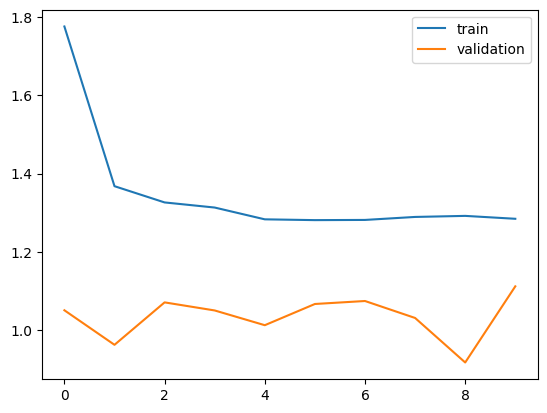

In [ ]:
# Training on CMATTERDB 3.1.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './BANGLA_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Bangla_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.1.1 test data
pretrained_weights = '/content/BANGLA_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_117_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_117 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_45 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_118 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_130 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_50 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_131 (Conv2D)         (None, 7, 7, 64)          4160      
      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 2s - loss: 2.0410 - accuracy: 0.4656 - val_loss: 1.2669 - val_accuracy: 0.5917 - 2s/epoch - 130ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.59167 to 0.65000, saving model to ./DEVANAGARI_RESNET_MNIST_MIX/best_lenet.hdf5
15/15 - 1s - loss: 1.3061 - accuracy: 0.5828 - val_loss: 1.1181 - val_accuracy: 0.6500 - 610ms/epoch - 41ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.65000
15/15 - 0s - loss: 1.2319 - accuracy: 0.6083 - val_loss: 1.0355 - val_accuracy: 0.6396 - 247ms/epoch - 16ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.65000
15/15 - 0s - loss: 1.2865 - accuracy: 0.6068 - val_loss: 1.0795 - val_accuracy: 0.6354 - 243ms/epoch - 16ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.65000 to 0.66875, saving model to ./DEVANAGARI_RESNET_MNIST_MIX/best_lenet.hdf5
15/15 - 1s - loss: 1.2834 - accuracy: 0.6083 - val_loss: 1.0504 - val_accuracy: 0.6687 - 577ms/epoch - 38ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve f

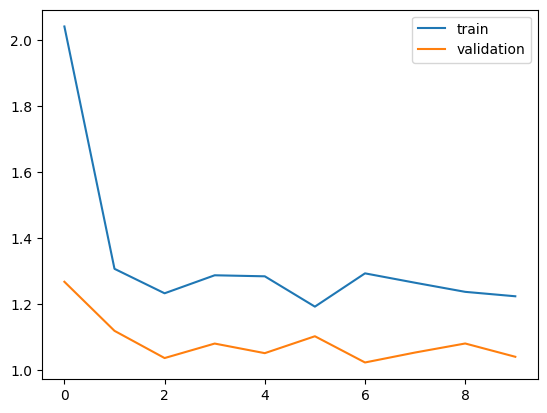

In [ ]:
# Training on CMATTERDB 3.2.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './DEVANAGARI_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Devanagari_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.2.1 test data
pretrained_weights = '/content/DEVANAGARI_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_143_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_143 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_55 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_144 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          

(192000, 28, 28, 1)
(48000, 28, 28, 1)
(40000, 28, 28, 1)
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_156_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_156 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_60 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_157 (Conv2D)         (None, 7, 7, 64)          4160      


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 - 28s - loss: 0.1880 - accuracy: 0.9738 - val_loss: 0.1162 - val_accuracy: 0.9839 - 28s/epoch - 18ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.98392
1500/1500 - 25s - loss: 0.2119 - accuracy: 0.9752 - val_loss: 0.1462 - val_accuracy: 0.9806 - 25s/epoch - 17ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.98392
1500/1500 - 26s - loss: 0.2203 - accuracy: 0.9757 - val_loss: 0.1270 - val_accuracy: 0.9811 - 26s/epoch - 17ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.98392
1500/1500 - 22s - loss: 0.2257 - accuracy: 0.9757 - val_loss: 0.1318 - val_accuracy: 0.9837 - 22s/epoch - 15ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.98392
1500/1500 - 25s - loss: 0.2307 - accuracy: 0.9756 - val_loss: 0.1332 - val_accuracy: 0.9826 - 25s/epoch - 17ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.98392
1500/1500 - 22s - loss: 0.2351 - accuracy: 0.9755 - val_loss: 0.1335 - val_accuracy: 0.9836 - 22s/epoch -

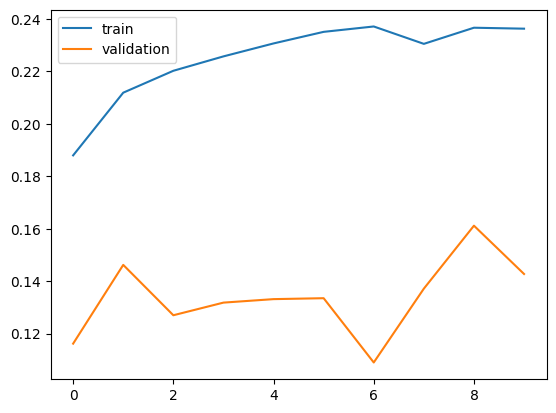

In [ ]:
# Training on EMNIST Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './EMNIST_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/EMNIST_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on EMNIST test data
pretrained_weights = '/content/EMNIST_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_169_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_169 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_65 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_170 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(20000, 28, 28, 1)
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_182_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_182 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_70 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_183 (Conv2D)         (None, 7, 7, 64)          4160      
 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 - 8s - loss: 1.2593 - accuracy: 0.6187 - val_loss: 0.8851 - val_accuracy: 0.6697 - 8s/epoch - 21ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.66967 to 0.69217, saving model to ./FARSI_RESNET_MNIST_MIX/best_lenet.hdf5
375/375 - 6s - loss: 1.2272 - accuracy: 0.6436 - val_loss: 0.8239 - val_accuracy: 0.6922 - 6s/epoch - 15ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.69217
375/375 - 5s - loss: 1.2567 - accuracy: 0.6445 - val_loss: 0.8446 - val_accuracy: 0.6869 - 5s/epoch - 14ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.69217 to 0.71767, saving model to ./FARSI_RESNET_MNIST_MIX/best_lenet.hdf5
375/375 - 6s - loss: 1.2466 - accuracy: 0.6503 - val_loss: 0.7857 - val_accuracy: 0.7177 - 6s/epoch - 16ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.71767
375/375 - 5s - loss: 1.2415 - accuracy: 0.6482 - val_loss: 0.8461 - val_accuracy: 0.6908 - 5s/epoch - 14ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.71767
3

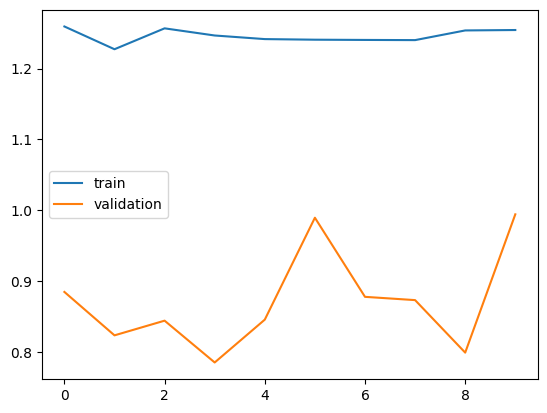

In [ ]:
# Training on FARSI Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './FARSI_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Farsi_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on FARSI test data
pretrained_weights = '/content/FARSI_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_195_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_195 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_75 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_196 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          

(15513, 28, 28, 1)
(3879, 28, 28, 1)
(4000, 28, 28, 1)
Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_208_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_208 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_80 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_209 (Conv2D)         (None, 7, 7, 64)          4160      
   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 - 4s - loss: 1.4056 - accuracy: 0.5758 - val_loss: 0.9884 - val_accuracy: 0.6827 - 4s/epoch - 35ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.68265
121/121 - 2s - loss: 1.3033 - accuracy: 0.6094 - val_loss: 0.9986 - val_accuracy: 0.6497 - 2s/epoch - 15ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.68265
121/121 - 3s - loss: 1.3214 - accuracy: 0.6139 - val_loss: 0.9380 - val_accuracy: 0.6757 - 3s/epoch - 21ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.68265 to 0.68600, saving model to ./ISIBANGLA_RESNET_MNIST_MIX/best_lenet.hdf5
121/121 - 2s - loss: 1.3343 - accuracy: 0.6120 - val_loss: 0.9439 - val_accuracy: 0.6860 - 2s/epoch - 18ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.68600
121/121 - 2s - loss: 1.3144 - accuracy: 0.6191 - val_loss: 1.0803 - val_accuracy: 0.6582 - 2s/epoch - 15ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.68600
121/121 - 2s - loss: 1.3450 - accuracy: 0.6173 - val_loss: 

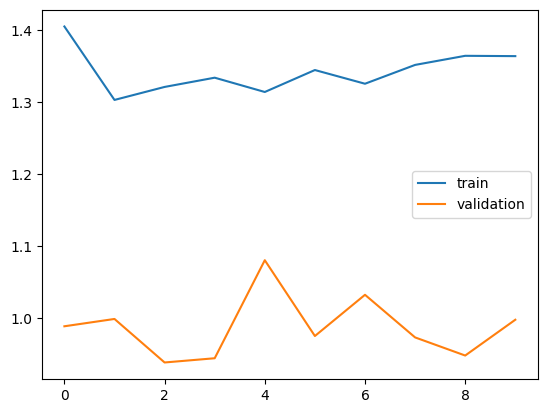

In [ ]:
# Training on ISI BANGLA Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ISIBANGLA_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/ISI_Bangla_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on ISI BANGLA test data
pretrained_weights = '/content/ISIBANGLA_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_221_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_221 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_85 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_222 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(20240, 28, 28, 1)
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_234_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_234 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_90 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_235 (Conv2D)         (None, 7, 7, 64)          4160      
 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 - 8s - loss: 1.0437 - accuracy: 0.6735 - val_loss: 0.6955 - val_accuracy: 0.7713 - 8s/epoch - 21ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.77133 to 0.78358, saving model to ./KANNADA_RESNET_MNIST_MIX/best_lenet.hdf5
375/375 - 7s - loss: 1.0179 - accuracy: 0.6915 - val_loss: 0.6275 - val_accuracy: 0.7836 - 7s/epoch - 18ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.78358
375/375 - 6s - loss: 1.0260 - accuracy: 0.6928 - val_loss: 0.7549 - val_accuracy: 0.7095 - 6s/epoch - 16ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.78358
375/375 - 5s - loss: 1.0382 - accuracy: 0.6926 - val_loss: 0.8241 - val_accuracy: 0.6969 - 5s/epoch - 15ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.78358
375/375 - 6s - loss: 1.0382 - accuracy: 0.6947 - val_loss: 0.6596 - val_accuracy: 0.7810 - 6s/epoch - 15ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.78358
375/375 - 6s - loss: 1.0312 - accuracy: 0.6979 - val_loss: 0.

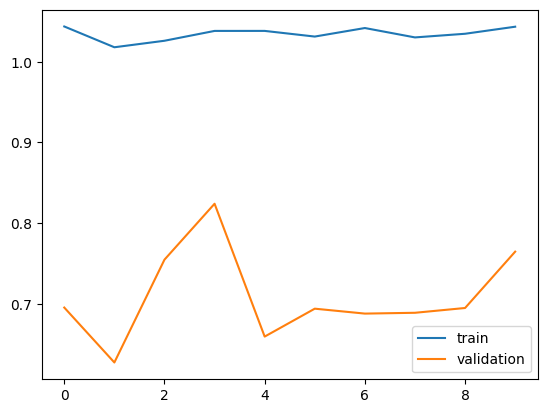

In [ ]:
# Training on Kannada Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './KANNADA_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Kannada_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on kannada test data
pretrained_weights = '/content/KANNADA_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_247_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_247 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_95 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_248 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_260_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_260 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_100 (B  (None, 14, 14, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_261 (Conv2D)         (None, 7, 7, 64)          4160      
 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 - 8s - loss: 0.8568 - accuracy: 0.7449 - val_loss: 0.5423 - val_accuracy: 0.8314 - 8s/epoch - 22ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.83142
375/375 - 5s - loss: 0.8377 - accuracy: 0.7622 - val_loss: 0.5998 - val_accuracy: 0.7996 - 5s/epoch - 14ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.83142
375/375 - 6s - loss: 0.8269 - accuracy: 0.7691 - val_loss: 0.5981 - val_accuracy: 0.8031 - 6s/epoch - 17ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.83142
375/375 - 5s - loss: 0.8362 - accuracy: 0.7670 - val_loss: 0.5342 - val_accuracy: 0.8267 - 5s/epoch - 15ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.83142
375/375 - 5s - loss: 0.8444 - accuracy: 0.7665 - val_loss: 0.5667 - val_accuracy: 0.8124 - 5s/epoch - 14ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.83142
375/375 - 6s - loss: 0.8386 - accuracy: 0.7700 - val_loss: 0.5695 - val_accuracy: 0.8147 - 6s/epoch - 15ms/step
Epoch 7/10

E

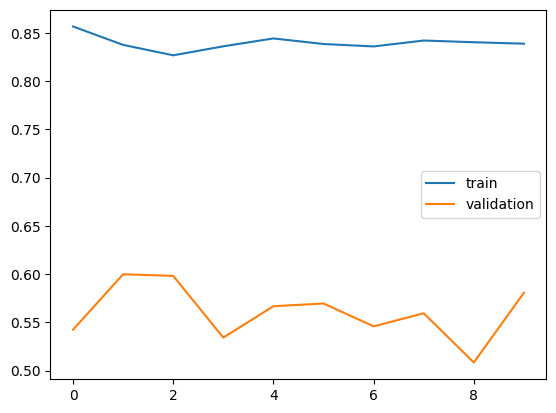

In [ ]:
# Training on MADBASE Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './MADBASE_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/MADBase_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on MADBASE test data
pretrained_weights = '/content/MADBASE_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_273_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_273 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_105 (B  (None, 14, 14, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_274 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_286_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_286 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_110 (B  (None, 14, 14, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_287 (Conv2D)         (None, 7, 7, 64)          4160      
      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 2s - loss: 2.1244 - accuracy: 0.4062 - val_loss: 1.2257 - val_accuracy: 0.6021 - 2s/epoch - 135ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.60208 to 0.66667, saving model to ./TELUGU_RESNET_MNIST_MIX/best_lenet.hdf5
15/15 - 1s - loss: 1.4304 - accuracy: 0.5448 - val_loss: 1.1307 - val_accuracy: 0.6667 - 855ms/epoch - 57ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.66667 to 0.70625, saving model to ./TELUGU_RESNET_MNIST_MIX/best_lenet.hdf5
15/15 - 1s - loss: 1.3610 - accuracy: 0.5714 - val_loss: 1.0427 - val_accuracy: 0.7063 - 777ms/epoch - 52ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.70625
15/15 - 0s - loss: 1.3304 - accuracy: 0.5578 - val_loss: 0.9984 - val_accuracy: 0.6875 - 340ms/epoch - 23ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.70625
15/15 - 0s - loss: 1.3255 - accuracy: 0.5781 - val_loss: 0.9727 - val_accuracy: 0.6979 - 340ms/epoch - 23ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.70

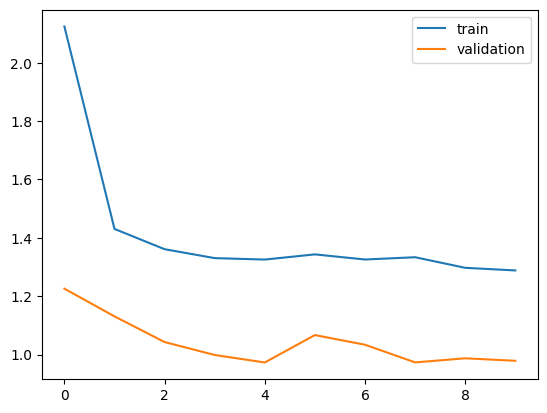

In [ ]:
# Training on CMATTERDB 3.4.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './TELUGU_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Telugu_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.4.1 test data
pretrained_weights = '/content/TELUGU_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_299_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_299 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_115 (B  (None, 14, 14, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_300 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_312_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_312 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_120 (B  (None, 14, 14, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_313 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 - 4s - loss: 1.3833 - accuracy: 0.5706 - val_loss: 1.0240 - val_accuracy: 0.6870 - 4s/epoch - 41ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.68695 to 0.71333, saving model to ./TIBETAN_RESNET_MNIST_MIX/best_lenet.hdf5
88/88 - 2s - loss: 1.2082 - accuracy: 0.6175 - val_loss: 0.9622 - val_accuracy: 0.7133 - 2s/epoch - 18ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.71333 to 0.71755, saving model to ./TIBETAN_RESNET_MNIST_MIX/best_lenet.hdf5
88/88 - 2s - loss: 1.1935 - accuracy: 0.6280 - val_loss: 0.9320 - val_accuracy: 0.7176 - 2s/epoch - 19ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.71755
88/88 - 1s - loss: 1.1897 - accuracy: 0.6295 - val_loss: 0.9259 - val_accuracy: 0.7176 - 1s/epoch - 15ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.71755 to 0.71790, saving model to ./TIBETAN_RESNET_MNIST_MIX/best_lenet.hdf5
88/88 - 3s - loss: 1.1954 - accuracy: 0.6282 - val_loss: 0.9459 - val_accuracy: 0.7179 - 3s/epoch - 29ms/step
Epoch 

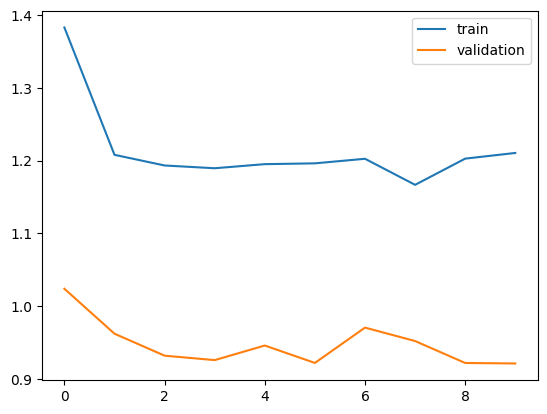

In [ ]:
# Training on Tibetan Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './TIBETAN_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Tibetan_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on TIBETAN test data
pretrained_weights = '/content/TIBETAN_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_325_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_325 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_125 (B  (None, 14, 14, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_326 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          

(5284, 28, 28, 1)
(1322, 28, 28, 1)
(1414, 28, 28, 1)
Model: "model_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_338_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_338 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_130 (B  (None, 14, 14, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_78 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_339 (Conv2D)         (None, 7, 7, 64)          4160      
    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 - 3s - loss: 1.5761 - accuracy: 0.5396 - val_loss: 0.9812 - val_accuracy: 0.6437 - 3s/epoch - 80ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.64372 to 0.67625, saving model to ./URDU_RESNET_MNIST_MIX/best_lenet.hdf5
41/41 - 1s - loss: 1.2562 - accuracy: 0.6141 - val_loss: 0.9950 - val_accuracy: 0.6762 - 1s/epoch - 29ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.67625
41/41 - 1s - loss: 1.2173 - accuracy: 0.6159 - val_loss: 0.9293 - val_accuracy: 0.6573 - 1s/epoch - 29ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.67625 to 0.69440, saving model to ./URDU_RESNET_MNIST_MIX/best_lenet.hdf5
41/41 - 2s - loss: 1.2445 - accuracy: 0.6147 - val_loss: 0.8608 - val_accuracy: 0.6944 - 2s/epoch - 38ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.69440
41/41 - 1s - loss: 1.2293 - accuracy: 0.6164 - val_loss: 0.9330 - val_accuracy: 0.6483 - 1s/epoch - 29ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.69440
41/41 - 1s - 

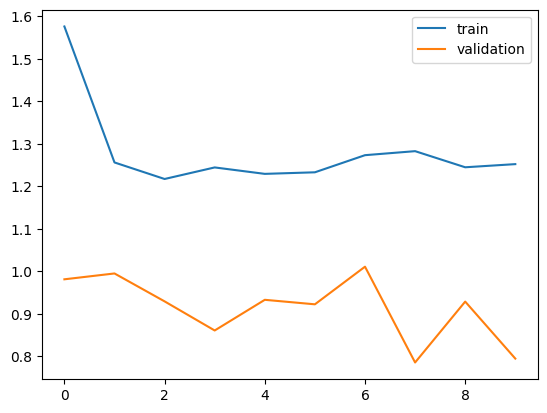

In [ ]:
# Training on URDU Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './URDU_RESNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Urdu_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on URDU test data
pretrained_weights = '/content/URDU_RESNET_MNIST_MIX/best_resnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_351_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_351 (Conv2D)         (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_135 (B  (None, 14, 14, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_81 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_352 (Conv2D)         (None, 7, 7, 64)          4160      
                                                          